In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import sqlalchemy as db
# from sqlalchemy import create_engine
# from sqlalchemy import MetaData 
# from sqlalchemy import Table

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('../databases/Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('../databases/Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
#shuffle data
labeled_data_sampled = labeled_data.sample(n=10000, random_state=1)

In [3]:
labeled_data_sampled.head()

-------------,ID,SourceID,RAdeg,DEdeg,Per,R21,phi21,T0,gmag,rmag,...,phi21_r,R2_g,R2_r,Amp_g,Amp_r,log(FAP_g),log(FAP_r),Type,Dmin_g,Dmin_r
342877,ZTFJ190042.20+144053.1,342878,285.17587,14.68142,0.409376,0.108,5.461,58351.231880,19.839,18.634,...,5.461,0.312,0.590,0.219,0.200,-4.312,-15.505,EW,0.085,0.035
744388,ZTFJ224047.05+653410.9,744391,340.19605,65.56972,0.537018,0.484,6.370,58389.300536,20.203,18.728,...,6.370,0.322,0.730,0.376,0.280,-4.199,-16.993,EA,0.048,0.007
433355,ZTFJ192547.84+230537.3,433356,291.44937,23.09370,0.619598,0.429,6.106,58582.480673,20.583,19.284,...,6.106,0.317,0.715,0.435,0.440,-0.516,-10.061,EA,0.185,0.317
276622,ZTFJ183148.91+340441.4,276623,277.95383,34.07817,0.438128,0.128,3.337,58605.486119,18.046,17.122,...,3.337,0.606,0.679,0.191,0.138,-24.496,-23.541,BYDra,0.000,0.000
318102,ZTFJ185126.29+311330.9,318103,282.85955,31.22526,0.432589,0.052,6.878,58234.374053,15.245,15.048,...,4.929,0.850,0.809,0.089,0.084,-24.736,-22.970,EW,0.018,0.020


In [4]:
engine = db.create_engine('sqlite:///../databases/save_LC.db', echo=False)
sqlite_connection = engine.connect()
metadata = db.MetaData()
data = db.Table('ZTFJ182806.98+011859.4', metadata, autoload=True, autoload_with=engine)
print(data.columns.keys())

['index', 'oid', 'expid', 'hjd', 'mjd', 'mag', 'magerr', 'catflags', 'filtercode', 'ra', 'dec', 'chi', 'sharp', 'filefracday', 'field', 'ccdid', 'qid', 'limitmag', 'magzp', 'magzprms', 'clrcoeff', 'clrcounc', 'exptime', 'airmass', 'programid']


In [5]:
metadata = db.MetaData()
metadata.reflect(bind=engine)
for table in metadata.sorted_tables:
    print(table)

ZTFJ182806.98+011859.4
ZTFJ185629.89-050650.2
ZTFJ192656.26+264100.6
ZTFJ194013.88+123401.3
ZTFJ200451.65-090628.4


In [6]:

#Equivalent to 'SELECT * FROM census'
query = db.select([data])
ResultProxy = sqlite_connection.execute(query)
ResultSet = ResultProxy.fetchall()


In [7]:
df = pd.DataFrame(ResultSet)
df.columns = ResultSet[0].keys()

In [8]:
circle_radius = 0.00028 # 1 arcsec = 0.00028 degress
t_format = "ipac_table"
table_format = "FORMAT=" + str(t_format)
flag_mask = 32768
mask = "BAD_CATFLAGS_MASK=" + str(flag_mask)
collect="COLLECTION="+"ztf_dr2"
numobs = "NOBS_MIN=20"
filter_band = "g"
label = []
SourceID =[]
start_time = time.time()
i = 100000
j = 100000
ra = labeled_data.RAdeg[i]
dec = labeled_data.DEdeg[i]
circle = "POS=CIRCLE"+"+"+str(ra)+"+"+str(dec)+"+"+str(circle_radius)
band = "BANDNAME="+ filter_band
params = circle + "&" +  mask + "&" + numobs + "&" + collect + "&" + table_format

url1= "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?" + params
data1 = pd.read_csv(url1, header=None, delim_whitespace=True, skiprows=55) # extract data
header = pd.read_csv(url1, header=None, sep='|', skiprows=50,usecols=range(1,25), nrows=1)
data1.columns = header.iloc[0].str.strip()


url2 = 'http://variables.cn:88/seldataz.php?SourceID=' + str(labeled_data.SourceID[j])
data2 = pd.read_csv(url2, header='infer')

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   oid          108 non-null    int64  
 1   expid        108 non-null    int64  
 2   hjd          108 non-null    float64
 3   mjd          108 non-null    float64
 4   mag          108 non-null    float64
 5   magerr       108 non-null    float64
 6   catflags     108 non-null    int64  
 7   filtercode   108 non-null    object 
 8   ra           108 non-null    float64
 9   dec          108 non-null    float64
 10  chi          108 non-null    float64
 11  sharp        108 non-null    float64
 12  filefracday  108 non-null    int64  
 13  field        108 non-null    int64  
 14  ccdid        108 non-null    int64  
 15  qid          108 non-null    int64  
 16  limitmag     108 non-null    float64
 17  magzp        108 non-null    float64
 18  magzprms     108 non-null    float64
 19  clrcoeff

In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SourceID  109 non-null    int64  
 1   RAdeg     109 non-null    float64
 2   DEdeg     109 non-null    float64
 3   HJD       109 non-null    float64
 4   mag       109 non-null    float64
 5   e_mag     109 non-null    float64
 6   flag      109 non-null    int64  
 7   band      109 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 6.9+ KB


In [11]:
print(labeled_data.SourceID[i])

100001


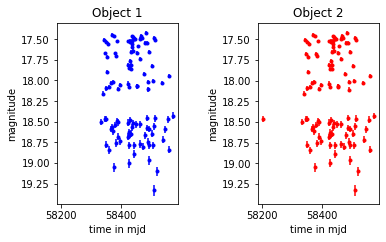

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
ax = axs[0]
ax.errorbar(data1['mjd'],data1['mag'],yerr = data1['magerr'],fmt='b.')
ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
ax.set_xlabel ('time in mjd')
ax.set_ylabel('magnitude')
ax.set_title('Object 1')

ax = axs[1]
ax.errorbar(data2['HJD'],data2['mag'],yerr = data2['e_mag'],fmt='r.')
ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
ax.set_xlabel('time in mjd')
ax.set_ylabel('magnitude')
ax.set_title('Object 2')

fig.tight_layout(pad=3.0)
plt.show()

In [13]:
data1.tail(100)

,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,...,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
8,509114200008984,62144655,2.458376e+06,58375.446551,19.052246,0.054551,0,zg,72.528890,14.963207,...,14,2,21.650000,26.269091,0.027871,-0.048050,0.000009,30,1.273,1
9,509114200008984,62448285,2.458379e+06,58378.482859,18.538534,0.039701,0,zg,72.528865,14.963201,...,14,2,21.719999,26.295378,0.027649,-0.055068,0.000009,30,1.127,1
10,509114200008984,62844208,2.458383e+06,58382.442083,18.757996,0.045292,0,zg,72.528871,14.963193,...,14,2,21.910000,26.252628,0.025815,-0.048184,0.000007,30,1.211,1
11,509114200008984,63145935,2.458386e+06,58385.459352,18.488382,0.038562,0,zg,72.528893,14.963187,...,14,2,20.469999,26.284616,0.039939,-0.044134,0.000028,30,1.136,1
12,509114200008984,63442784,2.458389e+06,58388.427847,18.506578,0.038969,0,zg,72.528873,14.963223,...,14,2,20.450001,26.242039,0.039162,-0.053573,0.000028,30,1.204,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,509214200005587,75321601,2.458508e+06,58507.216019,18.006100,0.026535,0,zr,72.528892,14.963206,...,14,2,20.980000,26.205782,0.019605,0.074618,0.000004,30,1.097,1
104,509214200005587,75621372,2.458511e+06,58510.213727,17.486906,0.019828,0,zr,72.528861,14.963236,...,14,2,19.860001,25.763767,0.033753,0.079776,0.000013,30,1.106,1
105,509214200005587,76013347,2.458515e+06,58514.133472,17.505764,0.020020,0,zr,72.528884,14.963201,...,14,2,21.549999,26.193560,0.020515,0.073348,0.000005,30,1.091,1
106,509214200005587,78412491,2.458539e+06,58538.124919,18.030725,0.026938,0,zr,72.528871,14.963231,...,14,2,20.540001,25.853170,0.025528,0.077948,0.000007,30,1.090,1


In [14]:
data2.head(100)

,SourceID,RAdeg,DEdeg,HJD,mag,e_mag,flag,band
0,100001,72.528879,14.963203,58450.42543,18.531,0.038,0,g
1,100001,72.528879,14.963203,58487.19866,18.458,0.037,0,g
2,100001,72.528879,14.963203,58439.43851,18.515,0.038,0,g
3,100001,72.528879,14.963203,58505.21812,18.642,0.041,0,g
4,100001,72.528879,14.963203,58507.18995,18.785,0.045,0,g
...,...,...,...,...,...,...,...,...
95,100001,72.528879,14.963201,58431.34506,17.516,0.020,0,r
96,100001,72.528879,14.963201,58441.31704,17.475,0.020,0,r
97,100001,72.528879,14.963201,58480.30204,17.543,0.020,0,r
98,100001,72.528879,14.963201,58354.44554,17.894,0.025,0,r


In [15]:
labeled_data.tail(10)

-------------,ID,SourceID,RAdeg,DEdeg,Per,R21,phi21,T0,gmag,rmag,...,phi21_r,R2_g,R2_r,Amp_g,Amp_r,log(FAP_g),log(FAP_r),Type,Dmin_g,Dmin_r
781592,ZTFJ235958.21+595322.6,781595,359.99257,59.88963,0.476594,0.036,6.535,58301.449595,18.066,17.195,...,6.535,0.704,0.813,0.186,0.171,-30.896,-43.850,EW,0.016,0.012
781593,ZTFJ235958.35+703634.9,781596,359.99313,70.60972,0.355792,0.328,6.288,58322.378712,18.691,17.624,...,6.288,0.944,0.986,0.723,0.683,-29.676,-33.249,EW,0.025,0.071
781594,ZTFJ235958.45+482611.7,781597,359.99358,48.43659,0.288055,0.266,6.392,58464.265978,15.898,15.298,...,6.300,0.828,0.795,0.105,0.094,-6.663,-4.822,EW,0.014,0.008
781595,ZTFJ235958.48+684200.6,781598,359.99369,68.70019,147.642302,0.256,5.975,58261.468212,18.863,15.534,...,5.975,0.533,0.644,0.727,0.536,-18.132,-21.327,SR,0.000,0.000
781596,ZTFJ235958.62+561627.3,781599,359.99429,56.27426,111.584841,0.151,5.162,58277.348115,12.656,0.000,...,0.000,0.436,0.000,0.064,0.000,-9.196,0.000,SR,0.000,0.000
781597,ZTFJ235958.71+540330.3,781600,359.99464,54.05844,0.316120,0.045,4.957,58285.403066,17.257,16.328,...,4.957,0.699,0.823,0.188,0.142,-14.759,-23.381,EW,0.063,0.016
781598,ZTFJ235958.84+625544.8,781601,359.99519,62.92912,0.299463,0.411,5.821,58279.407313,18.199,17.279,...,5.821,0.201,0.746,0.075,0.093,-4.014,-12.209,EW,0.005,0.008
781599,ZTFJ235959.18+532742.2,781602,359.99662,53.46174,0.512445,0.129,6.035,58365.349426,15.075,14.780,...,6.035,0.960,0.971,0.190,0.196,-26.888,-28.835,EW,0.025,0.027
781600,ZTFJ235959.38+683701.0,781603,359.99742,68.61696,0.471284,0.112,6.061,58358.415607,19.130,18.096,...,6.061,0.720,0.910,0.423,0.367,-23.633,-33.909,EW,0.078,0.066
781601,ZTFJ235959.45+522533.1,781604,359.99775,52.42587,2.413463,0.042,5.519,58289.460237,17.831,17.076,...,5.519,0.410,0.545,0.076,0.076,-9.747,-15.024,RSCVN,0.000,0.000


In [16]:
df_100000 = labeled_data[:100000]

<AxesSubplot:xlabel='Type', ylabel='Count'>

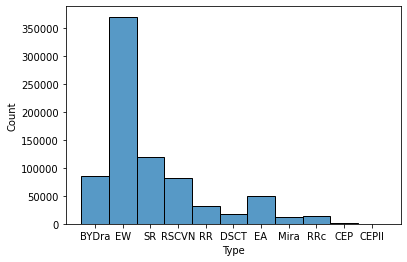

In [17]:
import seaborn as sns
sns.histplot(data=labeled_data, x=labeled_data.Type)

In [18]:
labeled_data.Type.value_counts()

EW       369707
SR       119261
BYDra     84697
RSCVN     81393
EA        49943
RR        32518
DSCT      16709
RRc       13875
Mira      11879
CEP        1262
CEPII       358
Name: Type, dtype: int64

In [19]:
lc = data2.drop(columns = ['SourceID','flag'])

In [20]:
print(lc.columns)

Index(['RAdeg', 'DEdeg', 'HJD', 'mag', 'e_mag', 'band'], dtype='object')


In [21]:
lc2 = data1[['ra','dec','hjd','mag','magerr','filtercode']]
col_names = lc.columns.values.tolist()

lc2.columns=['RAdeg', 'DEdeg', 'HJD', 'mag', 'e_mag', 'band']

In [22]:
lc2.band.unique()

array(['zg', 'zr'], dtype=object)

In [23]:
lc2.loc[lc2['band']=='zg']='g'
lc2.loc[lc2['band']=='zr']='r'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [24]:
lc2.band.unique()

array(['g', 'r'], dtype=object)

In [25]:
dfr = data2.loc[data2['band']=='r']
dfr.head()

dfg = data2.loc[data2['band']=='g']
dfg.head()

,SourceID,RAdeg,DEdeg,HJD,mag,e_mag,flag,band
0,100001,72.528879,14.963203,58450.42543,18.531,0.038,0,g
1,100001,72.528879,14.963203,58487.19866,18.458,0.037,0,g
2,100001,72.528879,14.963203,58439.43851,18.515,0.038,0,g
3,100001,72.528879,14.963203,58505.21812,18.642,0.041,0,g
4,100001,72.528879,14.963203,58507.18995,18.785,0.045,0,g


In [26]:
e_mag = dfr.e_mag.values
mag = dfr.mag.values

In [27]:
w = 1/(e_mag*e_mag)
sw = np.sum(w)
wmag = w*mag
wmean = np.sum(wmag)/sw

In [28]:
print(wmean)

17.674813386053117


In [29]:
e_mag = dfg.e_mag.values
mag = dfg.mag.values

w = 1/(e_mag*e_mag)
sw = np.sum(w)
wmag = w*mag
wmean = np.sum(wmag)/sw
print(wmean)

18.632181058166825


In [30]:
def weighted_mean(mag,mag_err):
    mag2 = (mag_err*mag_err) # mag err square
    mag2_inv = 1/mag2.values; # take inverse of the values
    w = pd.Series(mag2_inv) # covert it back to s series
    sw = w.sum() # sum of weights
    wmag = mag*w # multiply magnitude with weights
    wmean = wmag.sum()/sw # weighted mean
    return wmean

In [31]:
def weighted_mean2(mag,e_mag):
    w = 1/(e_mag*e_mag)
    sw = np.sum(w)
    wmag = w*mag
    wmean = np.sum(wmag)/sw
    return wmean

In [32]:
wmean_g = weighted_mean2(dfg.mag.values,dfg.e_mag.values)
wmean_r = weighted_mean2(dfr.mag.values,dfr.e_mag.values)
print(wmean_g)
print(wmean_r)

18.632181058166825
17.674813386053117


In [35]:
true_label = labeled_data.loc[labeled_data['SourceID']==1,'Type']
print(true_label.values[0])

BYDra
